In [2]:
import pandas as pd
import numpy as np
from matplotlib import pyplot

In [3]:
#Import the data --> this file represents only the train set
Data = pd.read_csv("Transformed.csv")
del Data["Unnamed: 0"]
Data.head()

,Industry,AgeRange,Gender,Year,NLT_Claims,LT_Claims,F_Claims,NLT_rating,LT_rating,F_rating
0,Transportation,65+,Male,2017.0,12.811065,8.282845,0.319687,3.0,3.0,1.0
1,Construction,25-29,Male,2015.0,21.518905,11.984111,0.290714,5.0,5.0,1.0
2,Construction,50-54,Male,2017.0,18.272725,11.257530,0.319687,4.0,4.0,1.0
3,Manufacturing,35-39,Male,2015.0,19.500555,10.927124,0.290714,5.0,4.0,1.0
4,Construction,60-64,Male,2013.0,13.363149,8.491301,0.290714,3.0,3.0,1.0


In [4]:
#import necessary packages
from numpy import mean
from numpy import std
from scipy.stats import sem
from scipy import stats
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import cross_val_score

In [5]:
#define the features (X) and target (y) --> using NLT_Claims as dependent variable
X = Data.drop(['NLT_Claims', 'LT_Claims', 'F_Claims', 'NLT_rating'], axis=1)
y = Data['NLT_rating']
print(list(X.columns.values))  #Remaining features used in the model

['Industry', 'AgeRange', 'Gender', 'Year', 'LT_rating', 'F_rating']


In [6]:
#Encode categories for Categorical variables --> Industry, AgeRange, Gender
import category_encoders as ce
#Industry
enc_Ind= ce.OrdinalEncoder(cols=['Industry'], mapping=[{'col':'Industry', 'mapping':{'Forestry':1, 'Manufacturing':2, 'Mining':3, 'Chemicals/Process':4,
       'Electrical':5, 'Health Care':6, 'Services':7, 'Transportation':8, '0.0':0, 'Food':9, 'Municipal':10, 'Agriculture':11, 'Construction':12, 'Education':13,
       'Automotive':14, 'Primary Metals':15, 'Pulp & Paper':16}}])
X['Ind_code'] = enc_Ind.fit_transform(X[['Industry']])
del X['Industry'] 

#Encode AgeRange
enc_Age= ce.OrdinalEncoder(cols=['AgeRange'], mapping=[{'col':'AgeRange',
'mapping':{'15-19':1, '20-24':2, '25-29':3, '30-34':4,'35-39':5, '40-44':6, '45-49':7, '50-54':8, '0.0':0,'55-60':9, '60-64':10, '65+':11}}])
X['Age_code'] = enc_Age.fit_transform(X[['AgeRange']])
del X['AgeRange'] 

#Encode Gender
enc_Gen= ce.OrdinalEncoder(cols=['Gender'],mapping=[{'col':'Gender','mapping':{'Female':1, 'Male':2}}])
X['Gen_code'] = enc_Gen.fit_transform(X[['Gender']])
del X['Gender'] 

X

,Year,LT_rating,F_rating,Ind_code,Age_code,Gen_code
0,2017.0,3.0,1.0,8,11.0,2.0
1,2015.0,5.0,1.0,12,3.0,2.0
2,2017.0,4.0,1.0,12,8.0,2.0
3,2015.0,4.0,1.0,2,5.0,2.0
4,2013.0,3.0,1.0,12,10.0,2.0
...,...,...,...,...,...,...
725,2019.0,4.0,1.0,2,5.0,2.0
726,2019.0,4.0,1.0,7,10.0,2.0
727,0.0,0.0,0.0,0,0.0,-1.0
728,2018.0,3.0,0.0,7,11.0,2.0


In [7]:
X_tr, X_ts, y_tr, y_ts = train_test_split(X, y, test_size = 0.3)

In [8]:
#configure the LogisticRegression function for multinomial logistic regression
LR_model = LogisticRegression(multi_class = 'multinomial',max_iter=1000)
print(LR_model.fit(X_tr, y_tr))

LogisticRegression(max_iter=1000, multi_class='multinomial')


C:\Users\eddym\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [9]:
y_predicted = LR_model.predict(X_ts)

In [10]:
#Create confusion matrix

from sklearn.metrics import confusion_matrix
con_matx = confusion_matrix(y_ts, y_predicted)
print(con_matx)

[[23 14  0  0  0  0]
 [ 4 22 10  0  0  0]
 [ 0 10 15 14  0  0]
 [ 0  0  8 26  4  1]
 [ 0  0  0  6 14 15]
 [ 0  0  0  0  5 28]]


In [11]:
from sklearn.metrics import classification_report
print(classification_report(y_ts, y_predicted))

              precision    recall  f1-score   support

         0.0       0.85      0.62      0.72        37
         1.0       0.48      0.61      0.54        36
         2.0       0.45      0.38      0.42        39
         3.0       0.57      0.67      0.61        39
         4.0       0.61      0.40      0.48        35
         5.0       0.64      0.85      0.73        33

    accuracy                           0.58       219
   macro avg       0.60      0.59      0.58       219
weighted avg       0.60      0.58      0.58       219



In [12]:
# create function to evaluate the model
def mod_eval(X, y, Reps):
    cv = RepeatedKFold(n_splits=10, n_repeats=Reps, random_state=1)
    model = LogisticRegression(multi_class = 'multinomial')
    scores = cross_val_score(model, X, y, scoring='accuracy', cv=cv, n_jobs=-1)
    return scores
 

# configurations to test
Reps = range(1,10)
results = list()
for r in Reps:
    scores = mod_eval(X, y, r)
    print('Run -> %d mean=%.4f se=%.3f' % (r, mean(scores), stats.sem(scores)))
    results.append(scores)

Run -> 1 mean=0.5658 se=0.023
Run -> 2 mean=0.5562 se=0.015
Run -> 3 mean=0.5644 se=0.011
Run -> 4 mean=0.5682 se=0.009
Run -> 5 mean=0.5704 se=0.010
Run -> 6 mean=0.5692 se=0.009
Run -> 7 mean=0.5667 se=0.008
Run -> 8 mean=0.5666 se=0.008
Run -> 9 mean=0.5642 se=0.008


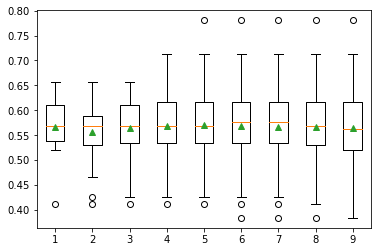

In [14]:
#plot the average accuracy
pyplot.boxplot(results, labels=[str(r) for r in Reps], showmeans=True)
pyplot.show()